In [ ]:
#import libraries
import numpy as np
# !pip install python-mnist
from mnist import MNIST
from sklearn.preprocessing import  LabelEncoder
from keras.utils import np_utils 
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
%matplotlib inline
from sklearn.metrics import accuracy_score
import time
# libraries needed to convert notebook to html file
# !pip install jupyter
# !pip install nbconvert
import nbconvert
import jupyter

In [ ]:
class LinearLayer:
   
    def __init__(self, input_shape, n_out, ini_type="plain"):
        """
        The constructor of the LinearLayer takes the following parameters
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
        """

        self.m = input_shape[1]  # number of examples in training data
        # `params` store weights and bias in a python dictionary
        self.params = initialize_parameters(input_shape[0], n_out, ini_type)  # initialize weights and bias
        self.Z = np.zeros((self.params['W'].shape[0], input_shape[1]))  # create space for resultant Z output

    def forward(self, A_prev):
        """
        This function performs the forwards propagation using activations from previous layer
        Args:
            A_prev:  Activations/Input Data coming into the layer from previous layer
        """

        self.A_prev = A_prev  # store the Activations/Training Data coming in
        self.Z = np.dot(self.params['W'], self.A_prev) + self.params['b']  # compute the linear function

    def backward(self, upstream_grad):
        """
        This function performs the back propagation using upstream gradients
        Args:
            upstream_grad: gradient coming in from the upper layer to couple with local gradient
        """

        # derivative of Cost w.r.t W
        self.dW = np.dot(upstream_grad, self.A_prev.T)

        # derivative of Cost w.r.t b, sum across rows
        self.db = np.sum(upstream_grad, axis=1, keepdims=True)

        # derivative of Cost w.r.t A_prev
        self.dA_prev = np.dot(self.params['W'].T, upstream_grad)

    def update_params(self, learning_rate=0.1):
        """
        This function performs the gradient descent update
        Args:
            learning_rate: learning rate hyper-param for gradient descent, default 0.1
        """
        self.params['W'] = self.params['W'] - learning_rate * self.dW  # update weights
        self.params['b'] = self.params['b'] - learning_rate * self.db  # update bias(es)



class SigmoidLayer:
    """
    This file implements activation layers
    inline with a computational graph model

    Args:
        shape: shape of input to the layer

    Methods:
        forward(Z)
        backward(upstream_grad)

    """

    def __init__(self, shape):
        """
        The consturctor of the sigmoid/logistic activation layer takes in the following arguments

        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function

        Args:
            Z: input from previous (linear) layer
        """
        self.A = 1 / (1 + np.exp(-Z))  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)


class SoftmaxLayer:
    """
    This file implements activation layers
    inline with a computational graph model

    Args:
        shape: shape of input to the layer

    Methods:
        forward(Z)
        backward(upstream_grad)

    """

    def __init__(self, shape,Y):
        """
        The consturctor of the softmax activation layer takes in the following arguments

        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations
        self.m = shape[1]
        self.Y = Y

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = np.exp(Z) / np.sum(np.exp(Z),axis=0,keepdims=True)   # compute  activations
      
    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of softmax => (A-Y)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad*( self.A - self.Y)/self.m  

In [ ]:

def initialize_parameters(n_in, n_out, ini_type='plain'):
    """
    Helper function to initialize some form of random weights and Zero biases
    Args:
        n_in: size of input layer
        n_out: size of output/number of neurons
        ini_type: set initialization type for weights

    Returns:
        params: a dictionary containing W and b
    """

    params = dict()  # initialize empty dictionary of neural net parameters W and b

    if ini_type == 'plain':
        params['W'] = np.random.randn(n_out, n_in) *0.01  # set weights 'W' to small random gaussian
    elif ini_type == 'xavier':
        params['W'] = np.random.randn(n_out, n_in) / (np.sqrt(n_in))  # set variance of W to 1/n
    elif ini_type == 'he':
        # Good when ReLU used in hidden layers
        # Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
        # Kaiming He et al. (https://arxiv.org/abs/1502.01852)
        # http: // cs231n.github.io / neural - networks - 2 /  # init
        params['W'] = np.random.randn(n_out, n_in) * np.sqrt(2/n_in)  # set variance of W to 2/n

    params['b'] = np.zeros((n_out, 1))    # set bias 'b' to zeros

    return params


In [ ]:
# grabbing the mnist images data sets from google drive
mndata = MNIST('/content/drive/MyDrive/ML606/mnistData')
mndata.gz = True
train_images, train_labels = mndata.load_training()
# # or
test_images, test_labels = mndata.load_testing()


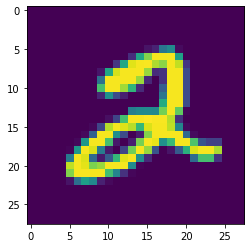

((60000, 784), 60000, (10000, 784), 10000)

In [ ]:
# preparing data sets and normalizing the images to avoid overflow
Xtrain = np.array(train_images)/255.0
Ytrain_labels = train_labels
Xtest= np.array(test_images) / 255.0
Ytest_labels =  test_labels

# show random image
random_index = np.int(np.random.rand()*10)
img = np.array(Xtrain[random_index]).reshape(28,28)
plt.imshow(img)
plt.show()
Xtrain.shape,len(Ytrain_labels), Xtest.shape,len(Ytest_labels)

In [ ]:
def encode_Labels(Y):
  """returns a 10-bit hot encoded vector of the labels"""
  feature_labels = np.array(Y) 
  encoder = LabelEncoder() 
  encoder.fit(feature_labels) 
  feature_labels = encoder.transform(feature_labels) 
  feature_labels = np_utils.to_categorical(feature_labels) 
  return feature_labels


# hot encoding the labels 
Y_train_encoded = encode_Labels(Ytrain_labels)
Y_test_encoded = encode_Labels(Ytest_labels)


# # transpose XX_train images
X_train = Xtrain.T
X_test = Xtest.T
# #Transpose Y_train and Y_test
Y_train = Y_train_encoded.T
Y_test = Y_test_encoded.T

In [ ]:
# define training constants
learning_rate = 1
number_of_epochs = 600

np.random.seed(48) # set seed value so that the results are reproduceable
                  # (weights will now be initailzaed to the same pseudo-random numbers, each time)

# Our network architecture has the shape: 
#  (input)--> [Linear->Sigmoid] -> [Linear->Sigmoid]-->[Linear->Sigmoid] -> [Linear->Softmax]-->(output)  

#------ LAYER-1 ----- define hidden layer that takes in training data 
Z1 = LinearLayer(input_shape=X_train.shape, n_out=20, ini_type='xavier')

A1 = SigmoidLayer(Z1.Z.shape)


# #------ LAYER-2 ----- define output layer that take is values from hidden layer
Z2= LinearLayer(input_shape=A1.A.shape, n_out=20, ini_type='xavier')
# layer two activation function -->sigmoid
A2= SigmoidLayer(Z2.Z.shape)


# #------ LAYER-3 ----- define 3rd hidden layer that take is values from hidden layer
Z3= LinearLayer(input_shape=A2.A.shape, n_out=20, ini_type='xavier')
A3= SigmoidLayer(Z3.Z.shape)

# #------ LAYER-4 ----- define output layer that take is values from hidden layer
Z4= LinearLayer(input_shape=A3.A.shape, n_out=10, ini_type='xavier')
# the last layer actication is softmax
A4= SoftmaxLayer(Z4.Z.shape,Y_train)

In [ ]:
def compute_cost(Y, Y_hat):
    """
    This function computes and returns the Cost and its derivative.
    The is function uses the Squared Error Cost function -> (1/m)*sum(Y*log(Y_hat))
    Args:
        Y: labels of data
        Y_hat: Predictions(activations) from a last layer, the output layer
    Returns:
        cost: The Squared Error Cost result
        dY_hat: gradient of Cost w.r.t the Y_hat
    """
    m = Y.shape[1]

    cost = (-1 / m) * np.sum(np.multiply(Y,np.log(Y_hat)))
    cost = np.squeeze(cost)  # remove extraneous dimensions to give just a scalar

    dY_hat = 1   # derivative of the  the cross-entropy with respect to Y_hat

    return cost, dY_hat


def predict(X, Y, Zs, As):
    """
    helper function to predict on data using a neural net model layers
    Args:
        X: Data in shape (features x num_of_examples)
        Y: labels in shape ( label x num_of_examples)
        Zs: All linear layers in form of a list e.g [Z1,Z2,...,Zn]
        As: All Activation layers in form of a list e.g [A1,A2,...,An]
    Returns::
        p: predicted labels
        probas : raw probabilities
        accuracy: the number of correct predictions from total predictions
    """
    m = X.shape[1]
    n = len(Zs)  # number of layers in the neural network
    p = np.zeros((1, m))

    # Forward propagation
    Zs[0].forward(X)
    As[0].forward(Zs[0].Z)
    for i in range(1, n):
        Zs[i].forward(As[i-1].A)
        As[i].forward(Zs[i].Z)
    probas = As[n-1].A
    return probas


def plot_learning_curve(costs, learning_rate, total_epochs, save=False):
    """
    This function plots the Learning Curve of the model
    Args:
        costs: list of costs recorded during training
        learning_rate: the learning rate during training
        total_epochs: number of epochs the model was trained for
        save: bool flag to save the image or not. Default False
    """
    # plot the cost
    plt.figure()

    steps = int(total_epochs / len(costs))  # the steps at with costs were recorded
    plt.ylabel('Cost')
    plt.xlabel('Iterations ')
    plt.title("Learning rate =" + str(learning_rate))
    plt.plot(np.squeeze(costs))
    locs, labels = plt.xticks()
    plt.xticks(locs[1:-1], tuple(np.array(locs[1:-1], dtype='int')*steps))  # change x labels of the plot
    plt.xticks()
    if save:
        plt.savefig('Cost_Curve.png', bbox_inches='tight')
    plt.show()


In [ ]:
costs = [] # initially empty list, this will store all the costs after a certian number of epochs

# Start training
start_time = time.time()
for epoch in range(number_of_epochs):
    
    # ------------------------- forward-prop -------------------------
    Z1.forward(X_train)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)

    Z3.forward(A2.A)
    A3.forward(Z3.Z)

    Z4.forward(A3.A)
    A4.forward(Z4.Z)
    
    # ---------------------- Compute Cost ----------------------------
        # cost, dA4 = compute_cost(Y=Y_tr, Y_hat=A4.A)

    cost, dA4 = compute_cost(Y=Y_train, Y_hat=A4.A)
  
    
    # print and store Costs every 100 iterations.
    if (epoch % 100) == 0:
        #print("Cost at epoch#" + str(epoch) + ": " + str(cost))
        print("Cost at epoch#{}: {}".format(epoch, cost))
        costs.append(cost)
    
    # ------------------------- back-prop ----------------------------
    A4.backward(dA4)
    Z4.backward(A4.dZ)

    A3.backward(Z4.dA_prev)
    Z3.backward(A3.dZ)
    
    A2.backward(Z3.dA_prev)
    Z2.backward(A2.dZ)
    
    A1.backward(Z2.dA_prev)
    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z4.update_params(learning_rate=learning_rate)
    Z3.update_params(learning_rate=learning_rate)
    Z2.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)
finish_time = time.time()
print("Training time: = {} seconds".format(finish_time - start_time))

Cost at epoch#0: 2.372770380741633
Cost at epoch#100: 2.0063490762314355
Cost at epoch#200: 1.143499639772927
Cost at epoch#300: 0.891638174637359
Cost at epoch#400: 0.6929483184736431
Cost at epoch#500: 0.45625875617285166
Training time: = 518.9487202167511 seconds


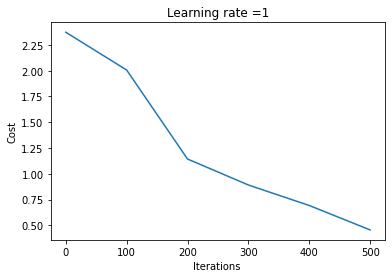

The  accuracy of the model on training data sets is: 90.46%
The accuracy of the model on testing data sets is: 90.37%


In [ ]:
#plot the learning curve to see if our model error was getting minimized
plot_learning_curve(costs,learning_rate,number_of_epochs)

# get the true labels
Y_test_true = test_labels.tolist()
Y_train_true = train_labels.tolist()
# see the ouptput predictions
train_predictions = predict(X=X_train, Y=Y_train, Zs=[Z1, Z2,Z3,Z4], As=[A1, A2,A3,A4])
test_predictions = predict(X=X_test, Y=Y_test, Zs=[Z1, Z2,Z3,Z4], As=[A1, A2,A3,A4])

Y_train_pred = train_predictions.argmax(axis=0)
Y_test_pred = test_predictions.argmax(axis=0)
training_accuracy = accuracy_score(Y_train_true,Y_train_pred)
testing_accuracy = accuracy_score(Y_test_true,Y_test_pred)

print("The  accuracy of the model on training data sets is: {:.2f}%".format(training_accuracy*100), end="\n")
print("The accuracy of the model on testing data sets is: {:.2f}%".format(testing_accuracy*100))

In [ ]:
# convert the notebook code to html file
!jupyter nbconvert --to html  /content/drive/MyDrive/HW2_V1.ipynb # notebook file path

[NbConvertApp] Converting notebook /content/drive/MyDrive/HW2_V1.ipynb to html
[NbConvertApp] Writing 335830 bytes to /content/drive/MyDrive/HW2_V1.html
